In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from regions import Regions
import numpy as np
from astropy import units as u
from astropy.nddata import Cutout2D
import os
import random
from random import seed
import shutil
from skimage.io import imread,imshow
from skimage.transform import resize
from tqdm import tqdm

# Loading the fits file

In [5]:
hdul = fits.open('../../../data files/ngc0628_miri_f770w_anchored.fits')
regions = Regions.read('../../../data files/jwst-bubbles-v0p1.reg',format='ds9')
hdul.info()

Filename: ../../../data files/ngc0628_miri_f770w_anchored.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (2968, 2938)   float64   


## Splitting the original image, bubble image and the masked image.

# Creating training images from cutouts

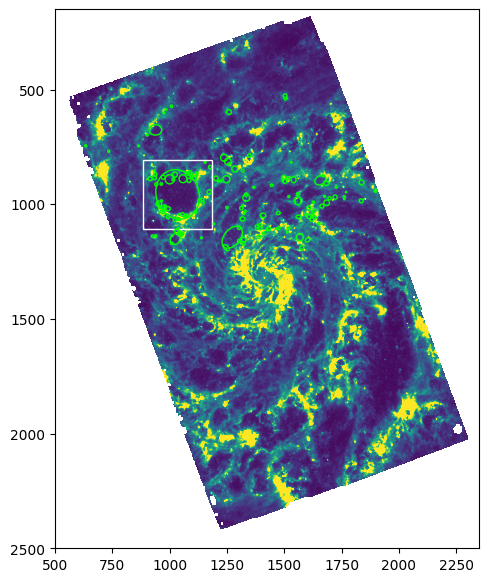

In [6]:
data = hdul[0].data
header = hdul[0].header

#Perform coordinate transforamtion:
wcs = WCS(header)

fig, ax = plt.subplots(figsize=(7,7))
#Show map in World Coordinate System transform from axes
#plt.subplot(projection=wcs)


plt.ylim(2500,150)
plt.xlim(500,2350)
ax.imshow(data, vmin=0, vmax=7)

for i,region in enumerate(regions[100:250]):
    pixel_region = region.to_pixel(wcs)
    if region == regions[132]:
        position = (pixel_region.center.x,pixel_region.center.y)
        size = u.Quantity((300,300), u.pixel)
        cutout = Cutout2D(data,position,size)
        cutout.plot_on_original(color='white')
    pixel_region.plot(ax=ax)
# plt.savefig('../Presentation 6_FEB/sample_cutout.png')

In [7]:
# fig, ax = plt.subplots(figsize=(7,7))
# data_original = imread('./original.png/')
# plt.imshow(data_original)

# Multiple masks in a single input image when matrix elements go from 0 to 1

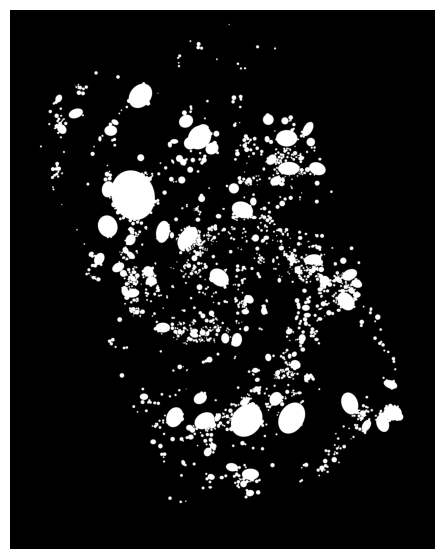

In [8]:
fig, ax = plt.subplots(figsize=(7,7))
shape = data.shape

final_matrix = np.zeros((shape))

for i,region in enumerate(regions):
    pixel_region = region.to_pixel(wcs)
    mask = pixel_region.to_mask(mode='exact')
    mask_matrix = mask.to_image(shape)
    final_matrix += mask_matrix
    
final_matrix[final_matrix > 1] = 1
#final_matrix[final_matrix == 0] = np.nan
plt.ylim(2500,150)
plt.xlim(500,2350)
plt.imshow(final_matrix,cmap='gray')
plt.gca().set_axis_off() # responsible for removing axes.
#plt.savefig('masked.png',bbox_inches='tight',pad_inches = 0)
#plt.colorbar()

<Axes: >

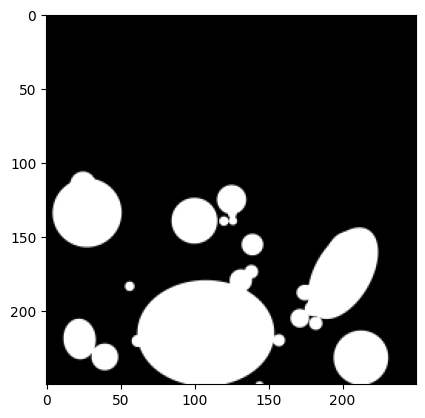

In [9]:
region = regions[0].to_pixel(wcs)
position = (region.center.x,region.center.y)
size = u.Quantity((250,250), u.pixel)

cutout = Cutout2D(final_matrix,position,size)

plt.imshow(cutout.data,cmap='gray')
cutout.plot_on_original(color='white')

# Class balance analysis(300,300)

100%|██████████████████████████████████████| 1695/1695 [00:05<00:00, 322.04it/s]


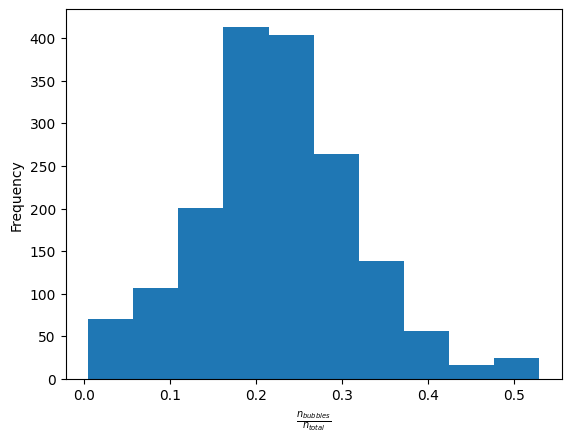

In [11]:
ratio = []
cutout_dim = 300
for i,region in tqdm(enumerate(regions),total=len(regions)):

    pixel_region = region.to_pixel(wcs)
    position = (pixel_region.center.x,pixel_region.center.y)
    size = u.Quantity((300,300), u.pixel)
    
    cutout_mask = Cutout2D(final_matrix,position,size)
    total_pixs = cutout_mask.shape[0]*cutout_mask.shape[1]
    foreground_pixs = np.count_nonzero(cutout_mask.data)
    ratio.append(foreground_pixs/total_pixs)
    
mean_ratio = np.mean(ratio)
plt.hist(ratio)
plt.xlabel(r'$\frac{n_{bubbles}}{n_{total}}$')
plt.ylabel('Frequency')
#plt.title(f'Cutout size = ({cutout_dim},{cutout_dim}), mean={mean_ratio:.{2}}')
plt.savefig('class_imbalance.png')
plt.show()
## As we can see, there is class imbalance as foreground/tot_pixs 
#peaks around 0.2.

100%|██████████████████████████████████████| 1695/1695 [00:02<00:00, 574.94it/s]


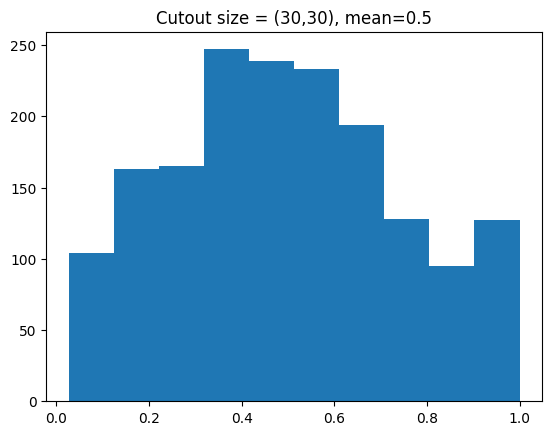

In [11]:
ratio = []
cutout_dim = 30
for i,region in tqdm(enumerate(regions),total=len(regions)):

    pixel_region = region.to_pixel(wcs)
    position = (pixel_region.center.x,pixel_region.center.y)
    size = u.Quantity((cutout_dim,cutout_dim), u.pixel)
    
    cutout_mask = Cutout2D(final_matrix,position,size)
    total_pixs = cutout_mask.shape[0]*cutout_mask.shape[1]
    foreground_pixs = np.count_nonzero(cutout_mask.data)
    ratio.append(foreground_pixs/total_pixs)

mean_ratio = np.mean(ratio)
plt.hist(ratio)
plt.title(f'Cutout size = ({cutout_dim},{cutout_dim}), mean={mean_ratio:.{2}}')
plt.show()